In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense

In [2]:
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

In [3]:
# всякие константы для последующей работы

#///////////////////////////////// для взятия данных из файлов

path_to_data = 'timesereis_8_2.csv' # путь к файлу, из которого берутся данные для обучения

#///////////////////////////////// для создания слоев

CRT_hidden_layer_act_fun = 'relu'   # функция активация скрытых слоев и входного
CRT_output_layer_act_fun = 'sigmoid' # функция активация выходного слоя

CRT_dict = {8: CRT_hidden_layer_act_fun, 
            400: CRT_hidden_layer_act_fun, 
            20: CRT_hidden_layer_act_fun,
            2: CRT_output_layer_act_fun} # size(layer) plus activation func

#///////////////////////////////// для компиляции 

CMP_learning_rate = 0.00005 # шаг сходимости back propogation
CMP_solver = keras.optimizers.Adam(CMP_learning_rate) # оптимизатор
CMP_loss_func = 'mean_squared_error'# функция потерь

#///////////////////////////////// для колбэков

    # для Early_stopping
ES_patience = 15 # кол-во эпох без улучшений
ES_min_delta = 0.0001 # минимальное улучшение параметра за cur_patience
ES_monitor_parametr =  'loss' # отслеживаемый параметр 
ES_save_best_weights = True # сохранять ли веса нейронки с лучшими результатами
    
    # для ReduceLROnPlateau
RLPOP_monitor_parametr = 'val_loss'  # отслеживаемый параметр 
RLPOP_factor = 0.1 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
RLPOP_patience = 10 # кол-во эпох без улучшений
RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
RLPOP_min_delta = 0.0001 # порог изменения отслеживаемого значения
RLPOP_cooldown = 0 # количество эпох до возобновления работы после изменения шага сходимости
RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
#///////////////////////////////// для тренировки

FIT_batch_size = 4 #13, 4 # размер bach при обучении/тестировании
FIT_shuffle = True # перемешивать ли данные
FIT_verbose = True # выводить ли прогресс обучения в его процессее
FIT_epochs = 50 # количество эпох обучения
FIT_validation_split = 0.2 # процент валидационных данных, отсекаемых из тестовой выборки

In [4]:
# разделить данные на тренировочные и тестовые
def split(X,Y,factor):
    X_train=X[:factor]
    Y_train=Y[:factor]
    X_test=X[factor:]
    Y_test=Y[factor:]
    return X_train,Y_train,X_test,Y_test

In [5]:
# взять данные из файла
def prep_data_8_2_time(path):
    file = pd.read_csv(path)
    
    X = file[['0','1','2','3','4','5','6','7']]
    X = X / X.max()
    Y = file[['8','9']]
    Y = Y / Y.max()
    Y = np.asarray(Y)
    
    factor=int(.80 * X.shape[0])
    
    return split(X, Y, factor)

In [6]:
# создание архитектуры нейронки
model = keras.Sequential()

for x in CRT_dict.items():
    model.add(Dense(x[0], activation = x[1]))
    
model.compile(loss = CMP_loss_func, optimizer = CMP_solver)

In [7]:
# Создание и настройка колбэков
callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

temp = keras.callbacks.EarlyStopping(
            monitor = ES_monitor_parametr, 
            min_delta = ES_min_delta, 
            patience = ES_patience,
            restore_best_weights = ES_save_best_weights
            )
callback_list.append(temp)

temp = keras.callbacks.ReduceLROnPlateau(
            monitor = RLPOP_monitor_parametr, 
            factor = RLPOP_factor, 
            patience = RLPOP_patience, 
            verbose = RLPOP_verbose,
            mode = RLPOP_mode, 
            min_delta = RLPOP_min_delta, 
            cooldown = RLPOP_cooldown, 
            min_lr = RLPOP_min_lr
            )
callback_list.append(temp)

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [8]:
# подготовка данных

X_train,Y_train,X_test,Y_test = prep_data_8_2_time(path_to_data)

In [9]:
# тренировка модели
history = model.fit(
            X_train, 
            Y_train, 
            batch_size = FIT_batch_size, 
            epochs = FIT_epochs, 
            verbose = FIT_verbose, 
            validation_split = FIT_validation_split, 
            shuffle = FIT_shuffle, 
            callbacks = FIT_callback_list)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

159/171 [==========================>...] - ETA: 0s - loss: 0.0026    
Epoch 00034: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
164/171 [===========================>..] - ETA: 0s - loss: 0.0026
Epoch 00044: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-07.
171/171 [==============================] - 0s 398us/step - loss: 0.0026 - val_loss: 3.4992e-04


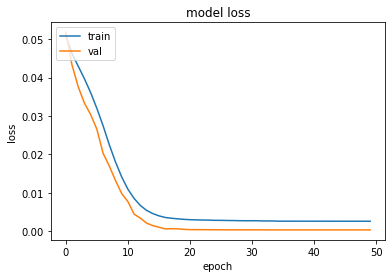

In [10]:
# Вывод графика изменения ошибки
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
# тест модели
model.evaluate(X_test, Y_test, batch_size = FIT_batch_size)

54/54 [==============================] - 0s 445us/step - loss: 6.5647e-04


0.0006564731593243778

In [12]:
model.save("NetWork_8_to_2")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: NetWork_8_to_2\assets
